## Reproducing Theory for Twisted Bilayer Photonic Crystal Slabs (PRL)
This notebook reproduces the results from Beicheng Lou's paper.

https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.136101

### Defining the structure

The structure is composed of three layers bathed in air ($\varepsilon=1$).
- Two twisted sieve-like films with $\varepsilon=4$ and air holes
- One air gap between the layer

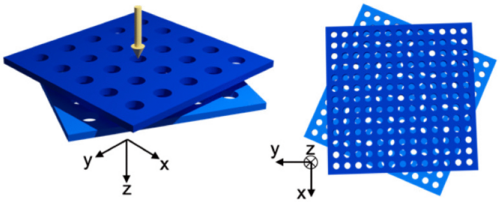


We first draw the patterned square unit cell used in the PhC. The drawing has here a resolution of 128 pixels squared and the background epsilon is 4.
The disc is of radius 0.25 with $\varepsilon=1$.

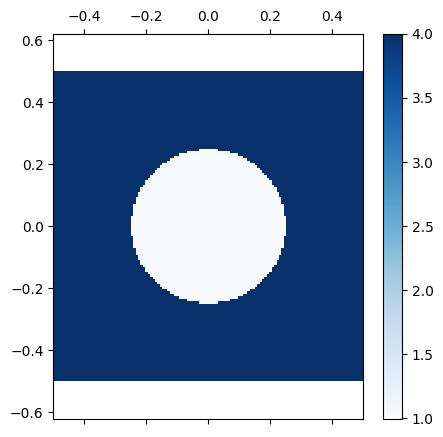

In [16]:
import sys
sys.path.append("..")
from khepri import Drawing
pattern = Drawing((128,128), 4)
pattern.disc(xy=(0, 0), radius=0.25, epsilon=1)
pattern.plot()

Before defining the Crystal, the twisted bilayer requires a special step. We will define the expansion of the Moiré lattice.
The base lattice will have for example 3 by 3 plane waves. The Moiré lattice is formed using rotation of the base lattices and the + operator provides the Minkowski sum.

In [17]:
from khepri import Expansion
import numpy as np
twist_angle = np.deg2rad(20)
plane_waves = (3, 3)
e1 = Expansion(plane_waves)
e2 = Expansion(plane_waves)
e1.rotate(twist_angle/2)
e2.rotate(-twist_angle/2)
moire_expansion = e1 + e2

Now that the pattern is drawn and the expansion defined, we can start defining the crystal layer by layer. We need to use the `add_layer` method here as the layers need to be assigned their specific expansions using the Layer constructor.

In [18]:
from khepri import Crystal, Layer
cl = Crystal.from_expansion(moire_expansion)
cl.add_layer("upper_layer", Layer.pixmap(e1, pattern.canvas(), 0.2), extended=True)
cl.add_layer("lower_layer", Layer.pixmap(e2, pattern.canvas(), 0.2), extended=True)
cl.add_layer("interlayer", Layer.uniform(e1, 1, 0.3), extended=True)

We can finally assemble the layer into the Crystal. We also se the te plane wave source and call solve.
After this step, the RCWA calculation is done!

In [19]:
cl.set_device(["upper_layer", "interlayer", "lower_layer"])
cl.set_source(wavelength=0.7, te=1, tm=0)
cl.solve()

In [20]:
# Poynting flux after the device
cl.poynting_flux_end()

(np.float64(0.27014385864375323), np.float64(0.7298561413562487))

Practically, you want to do all the above inside a function. This will enable easy parameter sweeps.

In [21]:
plane_waves = (3, 3)
def get_transmission(id):
    frequency, twist_angle = freq_and_ta_array[id]
    e1 = Expansion(plane_waves)
    e2 = Expansion(plane_waves)
    e1.rotate(twist_angle/2)
    e2.rotate(-twist_angle/2)
    moire_expansion = e1 + e2
    cl = Crystal.from_expansion(moire_expansion)
    cl.add_layer("upper_layer", Layer.pixmap(e1, pattern.canvas(), 0.2), extended=True)
    cl.add_layer("lower_layer", Layer.pixmap(e2, pattern.canvas(), 0.2), extended=True)
    cl.add_layer("interlayer", Layer.uniform(e1, 1, 0.3), extended=True)
    cl.set_device(["upper_layer", "interlayer", "lower_layer"])
    cl.set_source(wavelength=1/frequency, te=1, tm=0)
    cl.solve()
    return cl.poynting_flux_end()[1] # Return R, T

We now aim at obtaining the nice map in the article. We do so by varying twist and frequency from 0 to 45 deg and 0.7 to 0.83 c/a.
On an Apple 14' with standard M1 Chip on battery this takes 7'34'' for 50x50 map (2500 solve).
There is a way to make this MUCH faster (see below). I changed the sweep size to 5x5 to make the cells faster.

In [23]:
frequencies = np.linspace(0.7, 0.83, 5)
twist_angles = np.deg2rad(np.linspace(0, 45, 5))
from itertools import product
from tqdm import trange
freq_and_ta_array = list(product(frequencies, twist_angles))
TMAP = np.array([ get_transmission(i) for i in trange(len(freq_and_ta_array)) ])

100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


We finally plot our results! We write this in a function for later reuse. The map is horrible if you left the 5x5 resolution but go below for the faster version to do the 50x50.

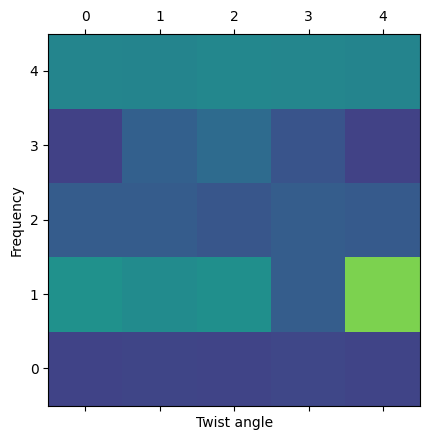

In [25]:
import matplotlib.pyplot as plt
def plotTMAP(MAP, shape):
    MAP = np.reshape(MAP, shape)
    plt.matshow(MAP, cmap="viridis", origin="lower", vmin=0, vmax=1)
    plt.xlim(np.min(twist_angles), np.max(twist_angles))
    plt.ylim(np.min(frequencies), np.max(frequencies))
    plt.axis("square")
    plt.xlabel("Twist angle")
    plt.ylabel("Frequency")
plotTMAP(TMAP, (5,5))

For a much faster version, we can work in parallel at the twist and wavelength level.
To do so we first disable all multithreading in numpy and khepri.
On my computer this takes  1m41 for a 50x50 map. In my case I can use 8 cores.

In [26]:
from multiprocessing.pool import ThreadPool

frequencies = np.linspace(0.7, 0.83, 50)
twist_angles = np.deg2rad(np.linspace(0, 45, 50))
from itertools import product
freq_and_ta_array = list(product(frequencies, twist_angles))
with ThreadPool(8) as p:
    TMAP = p.map(get_transmission, range(len(freq_and_ta_array)))

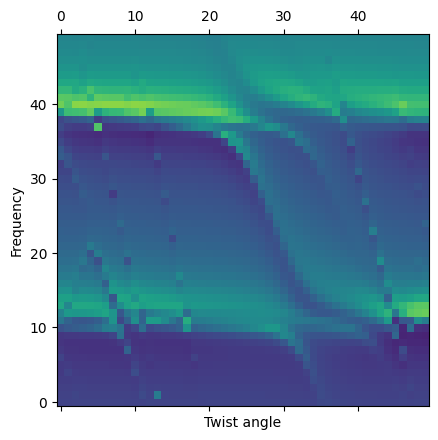

In [28]:
plotTMAP(TMAP, (50,50))